# Imagerie des galaxies sélectionnées

Ce code affiche pour une galaxie de l'échantillon son spectre sous W1, W3, W4, FUV et NUV, ainsi qu'une comparaison avec l'application des différents masques décrits dans le rapport du projet.

### Import

In [63]:
from astropy.table import Table
from astropy.io import fits
from astropy.wcs import WCS
from astropy.utils.data import download_file
import numpy as np
import matplotlib.pyplot as plt
import math
from matplotlib.colors import LogNorm

### Choix de la galaxie à cartographier

In [64]:
# Ce choix doit s'appuyer sur l'indice de la galaxie dans la table de données. 
# Dans l'éventualité où l'indice n'est pas connue, nous proposons 2 autres méthodes pour le retrouver (écrites sous 2 fonctions) 


# Fonction qui trouve l'indice à partir d'un numéro pgc 
def Index_by_PGC_number(x,t):
    for i in range(0,len(t)):
        if str(x)==str(t['pgc'][i]):
            return i
            break

# Fonction qui trouve l'indice à partir d'un nom 
def Index_by_name(x, t):
    for i in range(0,len(t)):
        if str(x)==str(t['objname'][i]):
            return i
            break


# Chargement de la table de données des échantillons sélectionnées
data = Table.read('donnees_finales.dat',format='ascii')


# Dans la suite du code, nous prenons pour exemple NGC4548, soit PGC41934 et le 5ème élément de la table de données

# Numéro PGC de la galaxie
name_pgc = 41934

# Nom de la galaxie
objname = 'NGC4548'

# Recherche de l'indice par ces 2 méthodes

i = Index_by_PGC_number(name_pgc,data)
#i = Index_by_name(objname,data)
#i = 5 Uniquement si on connait directement l'indice



## Masse stellaire et Star formation rate (SFR)

Nous rappelons les fonctions calculant la densité de masse stellaire et du SFR selon les formules données par [Leroy et al., 2019]

### Masse stellaire

In [65]:
def Stellar_Mass_function(intensity):
    upsilon_36=0.5 #msol/lsol
    result=3.3*(10**2)*(upsilon_36/0.5)*intensity #gives stellar mass in Solar Masses per parsec ^2
    return result

### Taux de formation stellaire

In [66]:
#Relation SFR (1)
#SFR determined by C-O Luminosity
def SFR_1(WISE,Lv):
    if (WISE==3):
        C = 10**-42.67                                       # Coefficient Kennicutt & Evans
    if (WISE==4):
        C = 10**-42.55                                       
    return (Lv*C)                                            # Lv = v.Lv here is the luminosity (in erg per second) 


#Relation ΣSFR (2) and (3)

def SFR_density(band,Ium):                                        # ΣSFR (result in this function) is in Msolar per year per pc^2
    if (band == 'W3'):                                            # In this case, the frequency v corresponds to lambda = 12 micrometer
        C = 10**(-42.9)
        #C = 10**(-42.67)                                         # for better estimations, you can use this value of C (WISE 3)
        Coef = (3.77*(10**-3))/(10**-42.9)
        result = Coef*C*Ium                                       # Intensity Ium in MJy per sr
    if (band == 'W4'):                                            # In this case, the frequency v corresponds to lambda = 22 micrometer
        C = 10**(-42.7)
        #C = 10**(-42.55)                                         # for better estimations, you can use this value of C (WISE 4)
        Coef = (3.24*(10**-3))/(10**-42.7)
        result = Coef*Ium*C                                                            
    if (band == 'NUV'):                                            # In this case, the frequency v corresponds to lambda = 22 micrometer
        C = 10**(-43.17)
        #C = 10**(−43.24)                                         # for better estimations, you can use this value of C (NUV)
        Coef = (1.05*(10**-1))/(10**-43.17) 
        result = Coef*Ium*C  
    if (band == 'FUV'):                                            # In this case, the frequency v corresponds to lambda = 22 micrometer
        C = 10**(-43.35)
        #C = 10**(-43.42)                                         # for better estimations, you can use this value of C (FUV)
        Coef = (1.04*(10**-1))/(10**-43.35)
        result = Coef*Ium*C  
    return result/10**6

### Fonction de conversion

In [67]:
### Conversion function
def pixel_conversion(distance, spectra):
    if 'CD1_1' not in spectra[0].header:
        CD1_1 = np.abs(spectra[0].header['CDELT1'])
    else:
        CD1_1 = np.abs(spectra[0].header['CD1_1'])
    
    dist_pc = distance*10**6 #converts distance in Mpc to distance in pc
    pixel_size_deg = abs(CD1_1)
    pixel_size_rad = np.deg2rad(pixel_size_deg) 
    pixel_size_pc = dist_pc * pixel_size_rad  
    return (pixel_size_pc ** 2)

### Fonction de masquage pour WISE 3

In [68]:
def Mask_W3(spectraa_W3, spectraa_W1):
    # make a new array that will become the mask for integrating the mass and SFR
    # initialise to NaNs
    galaxymask_W3_7p5=spectraa_W3[0].data*0.+np.nan
    # masque au dessus d'un palier W1/W3
    idx = np.where((spectraa_W3[0].data > 0.5) | (spectraa_W1[0].data > 0.2))
    galaxymask_W3_7p5[idx] = 1
    # on ajoute un masque circulaire par rapport à la distance depuis le centre de l'image (ici 60 pixels)
    w = WCS(spectraa_W3[0].header)
    naxis = w.pixel_shape
    ymat, xmat = np.indices((naxis[1], naxis[0]))
    w3x0=int(naxis[0]/2)
    w3y0=int(naxis[1]/2)
    dxmat=xmat-w3x0
    dymat=ymat-w3y0
    rmat=np.sqrt(dxmat*dxmat+dymat*dymat)
    idx = np.where(rmat > 60)
    galaxymask_W3_7p5[idx] = np.nan
    # multiplie l'image W1 par le masque
    masked_w1_true = spectraa_W1[0].data*galaxymask_W3_7p5
    return masked_w1_true


In [69]:
#Ouverture des fichiers depuis le répertoire courant

# Fichier FITS depuis WISE 1

filepath_W1 = 'File_Sample/irsa.ipac.caltech.edu/data/WISE/z0MGS/images/PGCXXX/PGCXXX_w1_gauss7p5.fits'
filepath_W1_stars = 'File_Sample/irsa.ipac.caltech.edu/data/WISE/z0MGS/images/PGCXXX/PGCXXX_w1_gauss7p5_stars.fits'

# Fichier FITS depuis WISE 3

filepath_W3 = 'File_Sample/irsa.ipac.caltech.edu/data/WISE/z0MGS/images/PGCXXX/PGCXXX_w3_gauss7p5.fits'
filepath_W3_stars = 'File_Sample/irsa.ipac.caltech.edu/data/WISE/z0MGS/images/PGCXXX/PGCXXX_w3_gauss7p5_stars.fits'

filepath_W3_15 = 'File_Sample/irsa.ipac.caltech.edu/data/WISE/z0MGS/images/PGCXXX/PGCXXX_w3_gauss15.fits'
filepath_W3_stars_15 = 'File_Sample/irsa.ipac.caltech.edu/data/WISE/z0MGS/images/PGCXXX/PGCXXX_w3_gauss15_stars.fits'

# Fichier FITS depuis WISE 4

filepath_W4 = 'File_Sample/irsa.ipac.caltech.edu/data/WISE/z0MGS/images/PGCXXX/PGCXXX_w4_gauss15.fits'
filepath_W4_stars = 'File_Sample/irsa.ipac.caltech.edu/data/WISE/z0MGS/images/PGCXXX/PGCXXX_w4_gauss15_stars.fits'

# Fichier FITS depuis NUV

filepath_NUV = 'File_Sample/irsa.ipac.caltech.edu/data/WISE/z0MGS/images/PGCXXX/PGCXXX_nuv_gauss15.fits'
path_NUV = 'File_Sample/irsa.ipac.caltech.edu/data/WISE/z0MGS/images/PGCXXX/'
filepath_NUV_stars = 'File_Sample/irsa.ipac.caltech.edu/data/WISE/z0MGS/images/PGCXXX/PGCXXX_nuv_gauss15_stars.fits'

# Fichier FITS depuis FUV

filepath_FUV = 'File_Sample/irsa.ipac.caltech.edu/data/WISE/z0MGS/images/PGCXXX/PGCXXX_fuv_gauss7p5.fits'
path_FUV = 'File_Sample/irsa.ipac.caltech.edu/data/WISE/z0MGS/images/PGCXXX/'
filepath_FUV_stars = 'File_Sample/irsa.ipac.caltech.edu/data/WISE/z0MGS/images/PGCXXX/PGCXXX_fuv_gauss7p5_stars.fits'

#####

### Acquisition des spectres de la galaxie d'étude

#####

Nous reprenons quelques éléments du code principal et nous affichons ensuite leurs spectres


In [70]:
key_NUV = 0
key_FUV = 0
this_filepath_W1 = filepath_W1.replace('XXX',str(data['pgc'][i]))
this_filepath_W1_stars = filepath_W1_stars.replace('XXX',str(data['pgc'][i]))
    
this_filepath_W3 = filepath_W3.replace('XXX',str(data['pgc'][i]))
this_filepath_W3_stars = filepath_W3_stars.replace('XXX',str(data['pgc'][i]))
    
this_filepath_W3_15 = filepath_W3_15.replace('XXX',str(data['pgc'][i]))
this_filepath_W3_stars_15 = filepath_W3_stars_15.replace('XXX',str(data['pgc'][i]))
    
this_filepath_W4 = filepath_W4.replace('XXX',str(data['pgc'][i]))
this_filepath_W4_stars = filepath_W4_stars.replace('XXX',str(data['pgc'][i]))

this_filepath_FUV = filepath_FUV.replace('XXX',str(data['pgc'][i]))
this_path_FUV = path_FUV.replace('XXX',str(data['pgc'][i]))
this_filepath_FUV_stars = filepath_FUV_stars.replace('XXX',str(data['pgc'][i]))

this_filepath_NUV = filepath_NUV.replace('XXX',str(data['pgc'][i]))
this_path_NUV = path_NUV.replace('XXX',str(data['pgc'][i]))
this_filepath_NUV_stars = filepath_NUV_stars.replace('XXX',str(data['pgc'][i]))
    

try:
    with fits.open(this_filepath_NUV) as NUV_hdu:
        key_NUV = 0  # File exists, set to 0
except FileNotFoundError:
    key_NUV = 1  # File doesn't exist, set to 1

try:
    with fits.open(this_filepath_FUV) as FUV_hdu:
        key_FUV = 0  # File exists, set to 0
except FileNotFoundError:
    key_FUV = 1  # File doesn't exist, set to 1
    



#Pour un échantillon donné, on traite tous les fichiers : 
    
#WISE 1 ( pour le calcul de la masse stellaire)
science_W1 = fits.open(this_filepath_W1)                            #Contient les données de la galaxie
mask_W1 = fits.open(this_filepath_W1_stars)                         #Masque des étoiles qui se situent devant elle
spectra_W1 = science_W1 + mask_W1                                   #Combine les deux pour obtenir le spectre final
W1 = spectra_W1[0].data



#WISE 3 7p5 resolution (pour appliquer le masquage)
science_W3 = fits.open(this_filepath_W3)                           
mask_W3 = fits.open(this_filepath_W3_stars)                       
spectra_W3 = science_W3 + mask_W3  
W3 = spectra_W3[0].data

#WISE 3 15 resolution (pour appliquer le masquage)
science_W3_15 = fits.open(this_filepath_W3_15)                           
mask_W3_15 = fits.open(this_filepath_W3_stars_15)                       
spectra_W3_15 = science_W3_15 + mask_W3_15
W3_15 = spectra_W3_15[0].data  
    
#WISE 4 (pour le calcul du SFR)
science_W4 = fits.open(this_filepath_W4)                           
mask_W4 = fits.open(this_filepath_W4_stars)                       
spectra_W4 = science_W4 + mask_W4
W4 = spectra_W4[0].data

#Distance de la galaxie
dist = data['distance'][i]
dist_pc = dist*10**6

#Application du masque
    
masked_w1 = Mask_W3(spectra_W3,spectra_W1)
masked_w4 = Mask_W3(spectra_W3_15,spectra_W4)


#Calculs de la masse stellaire et du SFR
total_stellar_mass_masked = np.nansum(Stellar_Mass_function(masked_w1)*pixel_conversion(dist, spectra_W1))
total_SFR_masked_W4 = np.nansum(SFR_density('W4',masked_w4)*pixel_conversion(dist, spectra_W4))
   
if (key_FUV == 0):
#FUV (pour le SFR)
    science_FUV = fits.open(this_filepath_FUV)                           
    mask_FUV = fits.open(this_filepath_FUV_stars)                       
    spectra_FUV = science_FUV + mask_FUV
    FUV = spectra_FUV[0].data
        
#SFR FUV
    masked_fuv = Mask_W3(spectra_W3,spectra_FUV)
    total_SFR_masked_FUV = np.nansum(SFR_density('FUV',masked_fuv)*pixel_conversion(dist, spectra_FUV))
    
if (key_FUV == 1):
     total_SFR_masked_FUV = np.nan

if (key_NUV == 0):
#NUV (for Star Formation Rate)
    science_NUV = fits.open(this_filepath_NUV)                           
    mask_NUV = fits.open(this_filepath_NUV_stars)                       
    spectra_NUV = science_NUV + mask_NUV
    NUV = spectra_NUV[0].data

#SFR NUV
    masked_nuv = Mask_W3(spectra_W3_15,spectra_NUV)
    total_SFR_masked_NUV = np.nansum(SFR_density('NUV',masked_nuv)*pixel_conversion(dist, spectra_NUV))
else:
    total_SFR_masked_NUV = np.nan


### Comparaison avec et sans masque W3

Nous commençons par visualiser le masque W3. L'objectif de cette section est de démontrer visuellement l'efficacité de l'application du masque W3 sur les spectres étudiés

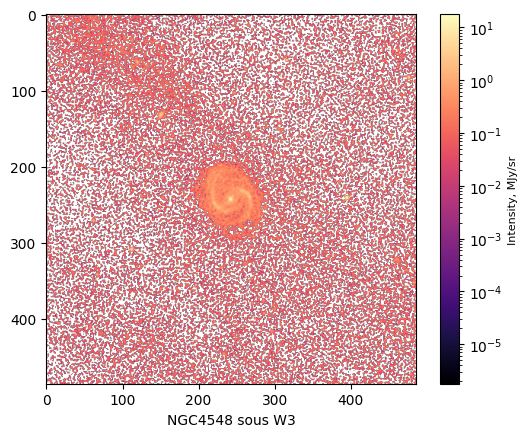

In [71]:
# Spectre W3

plt.imshow(W3, cmap='magma', norm=LogNorm())
plt.xlabel(str(data['objname'][i])+" sous W3")
plt.colorbar().set_label("Intensity, MJy/sr", fontsize=8)

Comparaison : Avant masquage W3

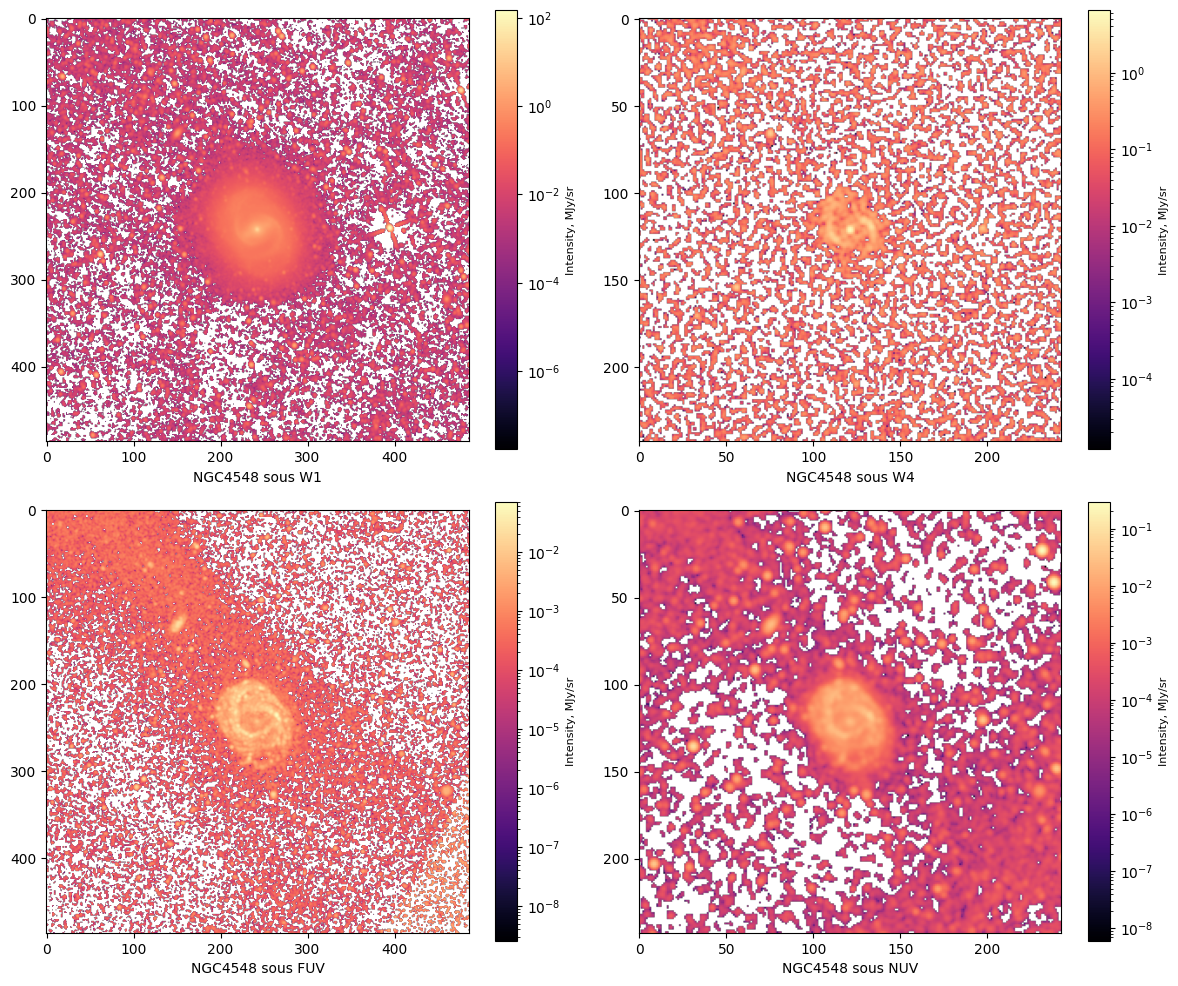

In [82]:

plt.figure(figsize = (12,10)) 


plt.subplot(2, 2, 1)
plt.imshow(W1, cmap='magma', norm=LogNorm())
plt.xlabel(str(data['objname'][i])+" sous W1")
plt.colorbar().set_label("Intensity, MJy/sr", fontsize=8)


plt.subplot(2, 2, 2)
plt.imshow(W4, cmap='magma', norm=LogNorm())
plt.xlabel(str(data['objname'][i])+" sous W4")
plt.colorbar().set_label("Intensity, MJy/sr", fontsize=8)


plt.subplot(2, 2, 3)
plt.imshow(FUV, cmap='magma', norm=LogNorm())
plt.xlabel(str(data['objname'][i])+" sous FUV")
plt.colorbar().set_label("Intensity, MJy/sr", fontsize=8)


plt.subplot(2, 2, 4)
plt.imshow(NUV, cmap='magma', norm=LogNorm())
plt.xlabel(str(data['objname'][i])+" sous NUV")


plt.colorbar().set_label("Intensity, MJy/sr", fontsize=8)
plt.tight_layout()      
plt.show()

Après Masquage W3

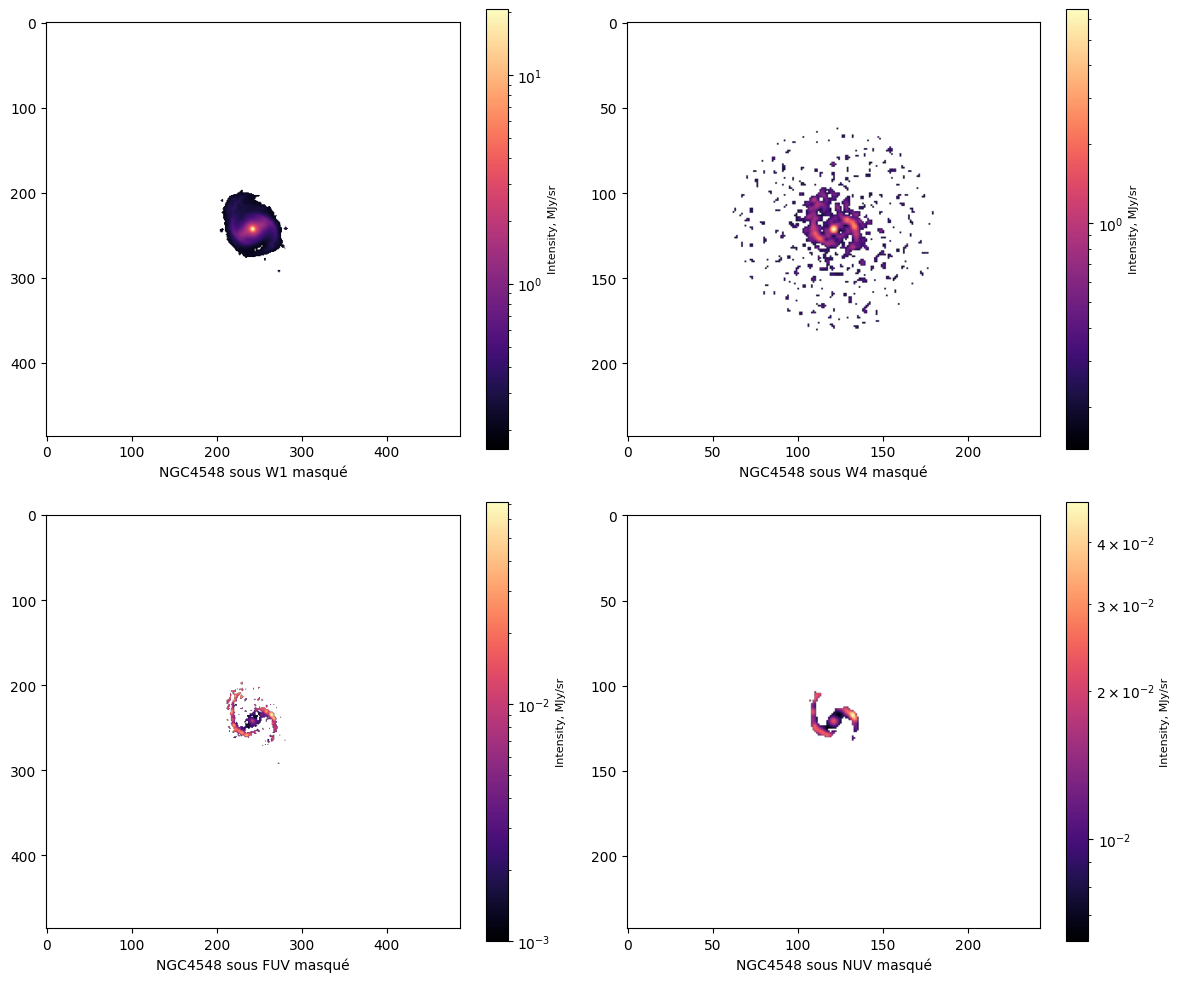

In [84]:
plt.figure(figsize = (12, 10)) 


plt.subplot(2, 2, 1)
plt.imshow(masked_w1, cmap='magma', norm=LogNorm())
plt.xlabel(str(data['objname'][i])+" sous W1 masqué")
plt.colorbar().set_label("Intensity, MJy/sr", fontsize=8)

plt.subplot(2, 2, 2)
plt.imshow(masked_w4, cmap='magma', norm=LogNorm())
plt.xlabel(str(data['objname'][i])+" sous W4 masqué")
plt.colorbar().set_label("Intensity, MJy/sr", fontsize=8)


plt.subplot(2, 2, 3)
plt.imshow(masked_fuv, cmap='magma', norm=LogNorm())
plt.xlabel(str(data['objname'][i])+" sous FUV masqué")
plt.colorbar().set_label("Intensity, MJy/sr", fontsize=8)


plt.subplot(2, 2, 4)
plt.imshow(masked_nuv, cmap='magma', norm=LogNorm())
plt.xlabel(str(data['objname'][i])+" sous NUV masqué")


plt.colorbar().set_label("Intensity, MJy/sr", fontsize=8)
plt.tight_layout()      
plt.show()

Après utilisation du masque W3, nous en déduisons la Masse Stellaire, ainsi que le SFR
 

### Cartographie Masse Stellaire et SFR après conversion et masquage W3

#### Cartographie Masse Stellaire

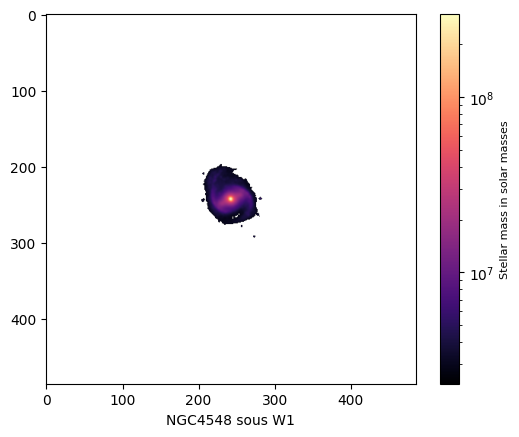

In [74]:
plt.imshow(Stellar_Mass_function(masked_w1)*pixel_conversion(dist, spectra_W1), cmap='magma', norm=LogNorm())
plt.xlabel(str(data['objname'][i])+" sous W1")
plt.colorbar().set_label("Stellar mass in solar masses", fontsize=8)
plt.show()

#### Cartographie SFR

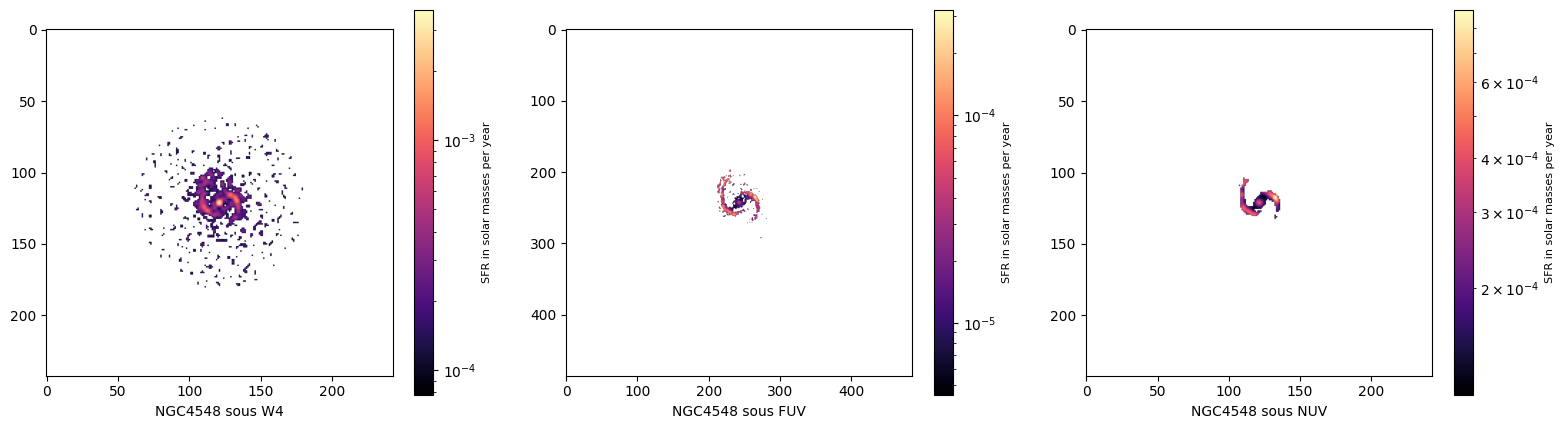

In [96]:
plt.figure(figsize = (19, 5)) 


plt.subplot(1, 3, 1)

plt.imshow(SFR_density('W4',masked_w4)*pixel_conversion(dist, spectra_W4), cmap='magma', norm=LogNorm())
plt.xlabel(str(data['objname'][i])+" sous W4")
plt.colorbar().set_label("SFR in solar masses per year", fontsize=8)


plt.subplot(1, 3, 2)

plt.imshow(SFR_density('FUV',masked_fuv)*pixel_conversion(dist, spectra_FUV), cmap='magma', norm=LogNorm())
plt.xlabel(str(data['objname'][i])+" sous FUV")
plt.colorbar().set_label("SFR in solar masses per year", fontsize=8)


plt.subplot(1, 3, 3)

plt.imshow(SFR_density('NUV',masked_nuv)*pixel_conversion(dist, spectra_NUV), cmap='magma', norm=LogNorm())
plt.xlabel(str(data['objname'][i])+" sous NUV")
plt.colorbar().set_label("SFR in solar masses per year", fontsize=8)
plt.show()